# 2D Data Driven World Assignment

## ● Names of the group members. 


Aravind Gopinath Nair– 1006057 

Toh Hengyi Lucas – 1006061 

Ang Yue Sheng – 1005964 

Lim Yong Qing – 1005955 

Rishika Banka – 1006304 

## ● Problem Statement

### o Background description of the problem

The United Nation and World Health Organization is forming a common taskforce together with industry leaders to address issues related to food security and safety. Such organisations require data-driven modelling to help them identify key factors to target to effectively solve the challenges in this area. 

According to WHO, poor sanitation is thought to be the main factor in some 432 000 of total diarrhoeal deaths. Furthermore, sanitation is a major factor in several neglected food-related tropical diseases, such as intestinal worms and parisitic worm disease of the gut. Furthermore, poor sanitation has an effect on malnutrition in a country.

### o User Personas 

- International Organisations (IGO)
IGOs such as the United Nations are organisations that are involved in global affairs. Such IGOs are in contact with industry leaders that are profit-driven, whose decisions are based on empirical data. With the data from countries provided, IGOs are more able to convince industry leaders and other world leaders to provide aid to countries in need.


- Non-profit Organisations
NPOs are involved in humanitarian and social services to provide foreign aid to countries in need. These organisations are not profit-driven, and as such, they would have fewer resources to hire a data team to analyse the countries of which they are helping to make more optimal decisions. These organisations would greatly benefit from having free public access data that enables them to optimise the usage of their resources.


- Policymakers
Within a country itself, there are policymakers that have a heavy influence over the lives of the people in the country through the laws they enforce. With data, policymakers are empowered to bring their policies into action with less delay. Through such policies, the country's standards of living would improve by enabling them to enact policies of successful nations and avoiding policies that are proven to be ineffective. As such, the standard of living in the country would be improved with less reliance on foreign aid.



### o Problem Statement using “how might we ...” statement 

How might we predict food safety in terms of the percentage of people with access to a basic level of sanitation in different countries by first identifying the most important and independent socio-economic factors and using them as inputs into a multilinear regression model?

 

## ● Data 

### o Link to data sources 

###### WHO Sanitation : 

https://www.who.int/news-room/fact-sheets/detail/sanitation




##### Datasets used : 

https://databank.worldbank.org/source/world-development-indicators 

Filters used for above : World Development Indicators | Low and Low-middle Income Countries | 2014-2016



###### Credibility of Data Source Worldbank : 

https://www.theguardian.com/global-development-professionals-network/2016/mar/16/the-top-10-sources-of-data-for-international-development-research


Definition of correlation coefficient r : https://corporatefinanceinstitute.com/resources/data-science/correlation/


### o Discussion on why these data were used, including any relevant visualizations 
Firstly, the data from Worldbank is credible according the TheGuardian.
Secondly, the data was more convenient to use as compared to FAO and Kaggle as all the data has a standardised csv format with fewer columns that are not relevant.
Thirdly, the data from Worldbank included socio-economic features as well as food security target csv data relevant to our project. 

To be specific about our data, we only chose countries in the low to lower middle income range for Years 2014 to 2016, which has the advantage of ensuring that the usage of median to fill in the NaN values is more effective when processing the data.

### o Code and steps to clean the data 

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
# Functions used to clean the data

# Extracts only relevant data columns from DataFrame which is only the Country Name, Feature Name, Value of Feature of one year
def select_year(dfin): 
    df = dfin.replace("..", np.nan)
    df = df[["Series Name","Country Name",dfin.columns[4]]]
    year = df.columns[2].rsplit()
    year = str(year[0])
    df[df.columns[1]] = df["Country Name"] + year
    df_out =df
    return df_out

# Creates new column : '(Country)+(Year)' to be used as index for each row of data in a DataFrame
def arrange_data(dfin): 
    country_dc = {}
    for country in dfin["Country Name"]:
            if country not in country_dc:
                    country_dc[country] = {}
                    
    for index,row in dfin.iterrows():
            country_dc[row[1]][row[0]]= row[2]
    return pd.DataFrame.from_dict(country_dc).T

# Calculates of mean of data of each column in a DataFrame and removes all data outside n_std standard deviations from mean
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

# r value here is to calculate correlation coefficient between 2 columns in a DataFrame.
def r_value(dfin,features_ls,target_ls):
    r_val_dict = {}
    for col in target_ls:
        r_val_dict[col] = {}
        for row in features_ls:
            
            feature1 = dfin[col]
            feature2 = dfin[row]
            
            feature1_mean = dfin[col].mean()
            feature2_mean = dfin[row].mean()
            
            feature1_diff = feature1 -feature1_mean
            feature2_diff = feature2 -feature2_mean
            
            numerator = (feature1_diff*feature2_diff).sum()
            denominator = np.sqrt((feature1_diff**2).sum()*(feature2_diff**2).sum())
            r_val = (numerator/denominator)
            r_val_dict[col][row] = r_val
    
    return pd.DataFrame(r_val_dict).T
            
# nan_percent =  threshold percentage of values in the column that is NaN
# Removes columns which have reach the threshold indicated (i.e removing features that have insufficient data)
def drop_cols(dfin,nan_percent = 0.05):
    dfout = pd.DataFrame(dfin)
    for (colname,colval) in dfin.items():
        nan_no = np.count_nonzero(np.isnan(colval.values))
        total_no = np.count_nonzero(colval.values)
        if (nan_no/total_no) >=nan_percent:
            dfout = dfout.drop(colname,axis=1)
    return dfout

# Inputs DataFrame and target(String) and returns a list of the target and features
def seperate_target_out(dfin,target):
    features_ls = list(dfin.columns)
    features_ls.remove(target)
    target_ls = [target]
    return target_ls, features_ls

# Replace NaN values in each column of the whole DataFrame with the median of each column
def add_median(dfin):
    data = []
    for column in dfin.columns:
        median = dfin[column].median()
        data.append(dfin[column].replace(np.nan,median))
    dfout =pd.concat(data,axis =1)
    return dfout

# r2 = r_value ** 2 (square of correlation coefficient)
# Using calculated r2 values of all features against the target, returns features that r2 value that is above the r2_threshold
def find_related_features(dfin,r2_threshold):
    column_name = dfin.columns[0]
    dfout = dfin[dfin[column_name]>= r2_threshold]
    return dfout

In [51]:
# Loading Data In
df_2014 = pd.read_csv("Raw Data/2014 Data.csv")
df_2015 = pd.read_csv("Raw Data/2015 Data.csv")
df_2016 = pd.read_csv("Raw Data/2016 Data.csv")

# Removing '..' values that represent no data in rows with NaN
df_2014 = df_2014.replace("..", np.nan)
df_2015 = df_2015.replace("..", np.nan)
df_2016 = df_2016.replace("..", np.nan)

In [52]:
# Combining Years 2014, 2015 and 2016 data to one CSV
df_2014_clean = select_year(df_2014)
df_2014_clean = arrange_data(df_2014_clean)

df_2015_clean = select_year(df_2015)
df_2015_clean = arrange_data(df_2015_clean)

df_2016_clean = select_year(df_2016)
df_2016_clean = arrange_data(df_2016_clean)

data = [df_2014_clean,df_2015_clean,df_2016_clean]
df_data = pd.concat(data).astype(float)
df_data.to_csv("Processed Data/Combined Data.csv")

df_col_dropped = drop_cols(df_data,nan_percent = 0.6) # Dropping features with >60% NaN values
display(df_col_dropped)
df_col_dropped.to_csv("Processed Data/Dropped.csv")

,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adolescents out of school (% of lower secondary school age),"Adolescents out of school, female (% of female lower secondary school age)","Adolescents out of school, male (% of male lower secondary school age)",Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Antiretroviral therapy coverage (% of people living with HIV),...,Trade (% of GDP),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)"
Afghanistan2014,NaN,NaN,NaN,NaN,NaN,NaN,92.649143,4.722937,87.926206,4.0,...,NaN,14.152000,10.110000,10.469000,7.20,11.142000,7.910000,21.681000,16.518000,17.570000
Algeria2014,NaN,NaN,NaN,NaN,NaN,NaN,51.509189,8.686205,42.822985,62.0,...,62.414316,15.581000,15.580000,8.961000,8.96,10.210000,10.210000,40.507000,22.832001,25.559000
Angola2014,NaN,NaN,NaN,NaN,NaN,NaN,97.942205,4.558697,93.383508,22.0,...,79.332923,7.754000,9.100000,6.999000,9.96,7.372000,9.580000,16.697001,16.764000,16.731001
Bangladesh2014,NaN,NaN,NaN,39.78434,33.550812,45.761269,53.578668,7.792943,45.785724,13.0,...,44.514080,7.482000,NaN,3.174000,NaN,4.384000,NaN,11.744000,9.814000,10.363000
Benin2014,96.36058,NaN,NaN,NaN,NaN,NaN,86.811436,6.030833,80.780603,41.0,...,65.268275,2.366000,NaN,1.906000,NaN,2.133000,NaN,5.078000,4.163000,4.664000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam2016,NaN,NaN,NaN,NaN,NaN,NaN,42.575372,9.730330,32.845043,53.0,...,NaN,1.699000,1.700000,1.989000,1.99,1.850000,1.850000,6.734000,6.763000,6.750000
West Bank and Gaza2016,95.77247,96.25543,95.3098,7.35438,5.404580,9.226390,74.344664,5.326847,69.017817,NaN,...,65.422514,37.952999,37.970001,20.570999,20.58,23.940001,23.940001,60.449001,33.678001,38.237000
"Yemen, Rep.2016",84.39664,78.87941,89.7010,28.44315,34.475868,22.633860,76.024870,4.973850,71.051020,24.0,...,25.276643,25.850000,NaN,12.311000,NaN,13.433000,NaN,34.591000,23.622000,24.660999
Zambia2016,NaN,NaN,NaN,NaN,NaN,NaN,91.971859,3.975174,87.996686,65.0,...,73.958561,11.667000,NaN,10.139000,NaN,10.872000,NaN,21.313999,19.726999,20.513000


In [53]:
# Replaces NaN values with the median of the column
df_median_filled = add_median(df_col_dropped)
display(df_median_filled)

,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adolescents out of school (% of lower secondary school age),"Adolescents out of school, female (% of female lower secondary school age)","Adolescents out of school, male (% of male lower secondary school age)",Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Antiretroviral therapy coverage (% of people living with HIV),...,Trade (% of GDP),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)"
Afghanistan2014,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,92.649143,4.722937,87.926206,4.0,...,61.969432,14.152000,10.110000,10.469000,7.20,11.142000,7.910000,21.681000,16.518000,17.570000
Algeria2014,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,51.509189,8.686205,42.822985,62.0,...,62.414316,15.581000,15.580000,8.961000,8.96,10.210000,10.210000,40.507000,22.832001,25.559000
Angola2014,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,97.942205,4.558697,93.383508,22.0,...,79.332923,7.754000,9.100000,6.999000,9.96,7.372000,9.580000,16.697001,16.764000,16.731001
Bangladesh2014,90.02310,85.70568,88.30147,39.784340,33.550812,45.761269,53.578668,7.792943,45.785724,13.0,...,44.514080,7.482000,5.610000,3.174000,4.83,4.384000,4.770000,11.744000,9.814000,10.363000
Benin2014,96.36058,85.70568,88.30147,19.433929,23.988251,22.195431,86.811436,6.030833,80.780603,41.0,...,65.268275,2.366000,5.610000,1.906000,4.83,2.133000,4.770000,5.078000,4.163000,4.664000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam2016,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,42.575372,9.730330,32.845043,53.0,...,61.969432,1.699000,1.700000,1.989000,1.99,1.850000,1.850000,6.734000,6.763000,6.750000
West Bank and Gaza2016,95.77247,96.25543,95.30980,7.354380,5.404580,9.226390,74.344664,5.326847,69.017817,33.0,...,65.422514,37.952999,37.970001,20.570999,20.58,23.940001,23.940001,60.449001,33.678001,38.237000
"Yemen, Rep.2016",84.39664,78.87941,89.70100,28.443150,34.475868,22.633860,76.024870,4.973850,71.051020,24.0,...,25.276643,25.850000,5.610000,12.311000,4.83,13.433000,4.770000,34.591000,23.622000,24.660999
Zambia2016,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,91.971859,3.975174,87.996686,65.0,...,73.958561,11.667000,5.610000,10.139000,4.83,10.872000,4.770000,21.313999,19.726999,20.513000


In [54]:
# Removing Outliers of 4 standard deviations or more away from the mean
df_trimmed = remove_outliers(df_median_filled,df_median_filled.columns,n_std = 4)
display(df_trimmed)

df_trimmed.to_csv("Processed Data/Data_trimmed.csv")

,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adolescents out of school (% of lower secondary school age),"Adolescents out of school, female (% of female lower secondary school age)","Adolescents out of school, male (% of male lower secondary school age)",Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Antiretroviral therapy coverage (% of people living with HIV),...,Trade (% of GDP),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)"
Afghanistan2014,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,92.649143,4.722937,87.926206,4.0,...,61.969432,14.152,10.11,10.469,7.20,11.142,7.91,21.681000,16.518,17.570000
Angola2014,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,97.942205,4.558697,93.383508,22.0,...,79.332923,7.754,9.10,6.999,9.96,7.372,9.58,16.697001,16.764,16.731001
Benin2014,96.36058,85.70568,88.30147,19.433929,23.988251,22.195431,86.811436,6.030833,80.780603,41.0,...,65.268275,2.366,5.61,1.906,4.83,2.133,4.77,5.078000,4.163,4.664000
Bolivia2014,87.94434,87.58961,88.28441,8.377710,8.631250,8.134330,65.210745,10.942778,54.267967,18.0,...,85.264470,2.878,2.85,1.373,1.36,2.020,2.02,7.061000,3.026,4.674000
Burkina Faso2014,68.30377,67.00632,69.55454,44.035610,44.668541,43.425480,93.014873,4.677294,88.337579,47.0,...,58.823562,4.370,9.24,4.039,3.86,4.188,6.48,7.415000,6.610,6.951000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Togo2016,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,80.939722,5.117856,75.821866,47.0,...,66.880569,2.225,5.61,3.661,4.83,2.966,4.77,5.696000,7.997,6.724000
Uganda2016,90.02310,85.70568,88.30147,45.985901,46.446339,45.524830,98.315236,3.769529,94.545707,65.0,...,31.209362,2.459,5.61,1.397,4.83,1.920,4.77,3.457000,2.211,2.822000
Uzbekistan2016,97.55430,85.70568,88.30147,4.833740,5.289210,4.398410,48.214408,6.138487,42.075921,39.0,...,29.192297,5.020,4.97,5.321,5.33,5.200,5.16,12.713000,12.102,12.320000
Vanuatu2016,90.02310,85.70568,88.30147,19.433929,23.988251,22.195431,74.217254,6.454137,67.763117,33.0,...,109.543485,1.542,5.61,1.957,4.83,1.776,4.77,4.362000,4.420,4.393000


In [55]:
# Creating DataFrame of R2 values of each feature against chosen target
target = "People using at least basic sanitation services (% of population)"
target_ls, features_ls = seperate_target_out(df_trimmed,target)
df_r2_target = r_value(df_trimmed,target_ls,features_ls)**2
display (df_r2_target)

,People using at least basic sanitation services (% of population)
"Adjusted net enrollment rate, primary (% of primary school age children)",0.090648
"Adjusted net enrollment rate, primary, female (% of primary school age children)",0.087637
"Adjusted net enrollment rate, primary, male (% of primary school age children)",0.043125
Adolescents out of school (% of lower secondary school age),0.219125
"Adolescents out of school, female (% of female lower secondary school age)",0.194294
...,...
"Unemployment, total (% of total labor force) (modeled ILO estimate)",0.106111
"Unemployment, total (% of total labor force) (national estimate)",0.129183
"Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)",0.203704
"Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)",0.198043


## ● Model 

### o Discussion on the predictors or features 

#### To find our 4 independent features from the set of 238 features, we will first find the features that correlate with the target.
#### We set r^2 value >= 0.2 as meaning that the target is correlated with the feature.

In [56]:
# Finding ONLY the features that are correlated to the target with threshold of r^2 >= 0.2 (i.e correlation coefficient = 0.5)
df_chosen_features = find_related_features(df_r2_target,r2_threshold = 0.2)
display(df_chosen_features)

,People using at least basic sanitation services (% of population)
Adolescents out of school (% of lower secondary school age),0.219125
Age dependency ratio (% of working-age population),0.507641
"Age dependency ratio, old (% of working-age population)",0.294637
"Age dependency ratio, young (% of working-age population)",0.513447
Domestic general government health expenditure (% of GDP),0.270962
...,...
"Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)",0.218267
"Labor force, female (% of total labor force)",0.233962
Ratio of female to male labor force participation rate (%) (modeled ILO estimate),0.298546
Renewable energy consumption (% of total final energy consumption),0.466654


#### From these 111 features that are correlated to the target, we will now find which 4 of these features are independent.

#### First, we will plot the correlation coefficient (r value) between each pair of the 111 features.

In [57]:
# Finding the r2 value between each feature, where r2 value is the square of the correlation coefficient
# Creating r2 matrix to see correlation between all 114 features
features_ls = list(df_chosen_features.index)
df_r2_features = r_value(df_trimmed,features_ls,features_ls)**2
display(df_r2_features)
df_r2_features.to_csv('Processed Data/R2_Comparison_Features.csv')

,Adolescents out of school (% of lower secondary school age),Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Domestic general government health expenditure (% of GDP),External health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",Individuals using the Internet (% of population),Lifetime risk of maternal death (%),"Lower secondary completion rate, female (% of relevant age group)",...,"Access to electricity, urban (% of urban population)","Agriculture, forestry, and fishing, value added (% of GDP)","Labor force participation rate for ages 15-24, female (%) (modeled ILO estimate)","Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)","Labor force participation rate, female (% of female population ages 15-64) (modeled ILO estimate)","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)","Labor force, female (% of total labor force)",Ratio of female to male labor force participation rate (%) (modeled ILO estimate),Renewable energy consumption (% of total final energy consumption),"Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)"
Adolescents out of school (% of lower secondary school age),1.000000,0.275289,0.120663,0.272981,0.112189,0.056382,0.047682,0.148841,0.270704,0.382958,...,0.116754,0.110781,0.050658,0.036340,0.038928,0.039052,0.027637,0.025560,0.174731,0.065192
Age dependency ratio (% of working-age population),0.275289,1.000000,0.443679,0.993676,0.174998,0.227840,0.258716,0.426620,0.581394,0.399592,...,0.498329,0.171770,0.103914,0.119525,0.109390,0.076871,0.114325,0.148266,0.357240,0.119539
"Age dependency ratio, old (% of working-age population)",0.120663,0.443679,1.000000,0.522976,0.273209,0.175636,0.101281,0.338485,0.260280,0.257894,...,0.249205,0.215696,0.071534,0.097716,0.088279,0.053820,0.083126,0.142252,0.255285,0.096318
"Age dependency ratio, young (% of working-age population)",0.272981,0.993676,0.522976,1.000000,0.195706,0.236224,0.255554,0.443193,0.577611,0.408809,...,0.499411,0.187904,0.106296,0.124430,0.113718,0.078728,0.117949,0.157090,0.367999,0.124706
Domestic general government health expenditure (% of GDP),0.112189,0.174998,0.273209,0.195706,1.000000,0.065350,0.228563,0.204626,0.240703,0.175094,...,0.082943,0.166606,0.022303,0.018939,0.014694,0.013861,0.013972,0.027470,0.169740,0.024060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)",0.039052,0.076871,0.053820,0.078728,0.013861,0.214752,0.000023,0.182954,0.025557,0.081058,...,0.178557,0.117028,0.896980,0.920100,0.916102,1.000000,0.613063,0.637888,0.396896,0.377563
"Labor force, female (% of total labor force)",0.027637,0.114325,0.083126,0.117949,0.013972,0.231667,0.005453,0.180600,0.058049,0.047983,...,0.222651,0.084713,0.643617,0.839071,0.837618,0.613063,1.000000,0.960128,0.501428,0.448558
Ratio of female to male labor force participation rate (%) (modeled ILO estimate),0.025560,0.148266,0.142252,0.157090,0.027470,0.266971,0.019975,0.221575,0.066982,0.060792,...,0.256145,0.081731,0.665328,0.871613,0.854881,0.637888,0.960128,1.000000,0.512813,0.439833
Renewable energy consumption (% of total final energy consumption),0.174731,0.357240,0.255285,0.367999,0.169740,0.251910,0.073487,0.526975,0.264689,0.281211,...,0.355397,0.284938,0.433020,0.491983,0.482923,0.396896,0.501428,0.512813,1.000000,0.326652


#### Producing the csv onto Excel, we checked for intersections between features where the R2 < 0.1.
#### R2 < 0.1 means that the 2 features do not correlate or correlate very weakly.
##### The intersections where R2 < 0.1 are labelled in red using Excel's conditional highlighting feature.

<img src="Images/R2_Feature_Comparison.JPG"
     alt="Image"
     style="float: left; margin-right: 10px;" />

#### To proceed, we first started with choosing 'Primary completion rate, total (% of relevant age group)' as one of our desired features.
#### Starting from the row in yellow, looking across all columns, we highlight any vertical column where its intersection with the yellow row is red.
#### From this, you can see that across the yellow row, there are 4 unique vertical columns intersecting it.
#### We disregard the yellow - yellow intersection because that's simply the feature against itself.

<img src="Images/R2_Feature_Comparison_4.JPG"
     alt="Image"
     style="float: left; margin-right: 10px;" />

#### We only selected the features that include a portion of the total population rather than a subset of the population.
#### For instance, 'People practicing open defecation (% of population)' vs 'People practicing open defecation, rural (% of rural population)'

#### After isolating the 5 features, to ensure independence between features, we did an Excel comparison of R2 values between them.

<img src="Images/R2_Feature_Comparison_5.JPG"
     alt="Image"
     style="float: left; margin-right: 10px;" />

#### As seen from above, yellow feature has low correlation with 4 other features.
#### It can also be seen that green feature shows correlation with 2 other features, which means that the green feature has to be discarded.
#### After discarding the green feature, we will obtain 4 features that are independent from one another.

<img src="Images/R2_Feature_Comparison_6.JPG"
     alt="Image"
     style="float: left; margin-right: 10px;" />

# From above, we can see that each feature is now not correlated to each of the other 4 factors.

#### Hence, from a total of 238 features, we narrowed it down to 111 features by finding the features that are solely finding those that are correlated to the target.
#### Next, we further narrowed 111 features to 5 selected features by using one of the 111 features as a reference.
#### Finally, we narrowed down from 5 features to 4 features after ensuring the selected features are independent.

In [58]:
# This is the final data set we will be using for the remainder of the code
df_final = df_trimmed[["Tuberculosis case detection rate (%, all forms)", "Labor force, female (% of total labor force)", "People practicing open defecation (% of population)", "Primary completion rate, total (% of relevant age group)", "People using at least basic sanitation services (% of population)"]]
df_final

,"Tuberculosis case detection rate (%, all forms)","Labor force, female (% of total labor force)",People practicing open defecation (% of population),"Primary completion rate, total (% of relevant age group)",People using at least basic sanitation services (% of population)
Afghanistan2014,50.0,18.275341,15.248276,88.059189,41.060966
Angola2014,54.0,49.363705,23.843090,88.059189,46.117029
Benin2014,61.0,49.444921,56.206296,79.454399,14.365499
Bolivia2014,63.0,42.971425,16.388945,90.711960,54.944525
Burkina Faso2014,59.0,44.990145,49.238977,60.849499,19.360444
...,...,...,...,...,...
Togo2016,80.0,48.444742,47.767991,92.715149,16.714317
Uganda2016,54.0,49.220145,6.463662,54.743011,19.253691
Uzbekistan2016,67.0,40.132749,0.000000,96.819221,100.000000
Vanuatu2016,64.0,43.608041,0.581828,88.059189,53.148221


#### This is a plot of each feature against each other and the target.
#### The target is on the y-axis of the bottom row below, and there is a visible pattern of each feature to the target.
#### The plot of each feature to another also shows little discernible pattern which validates the above findings.

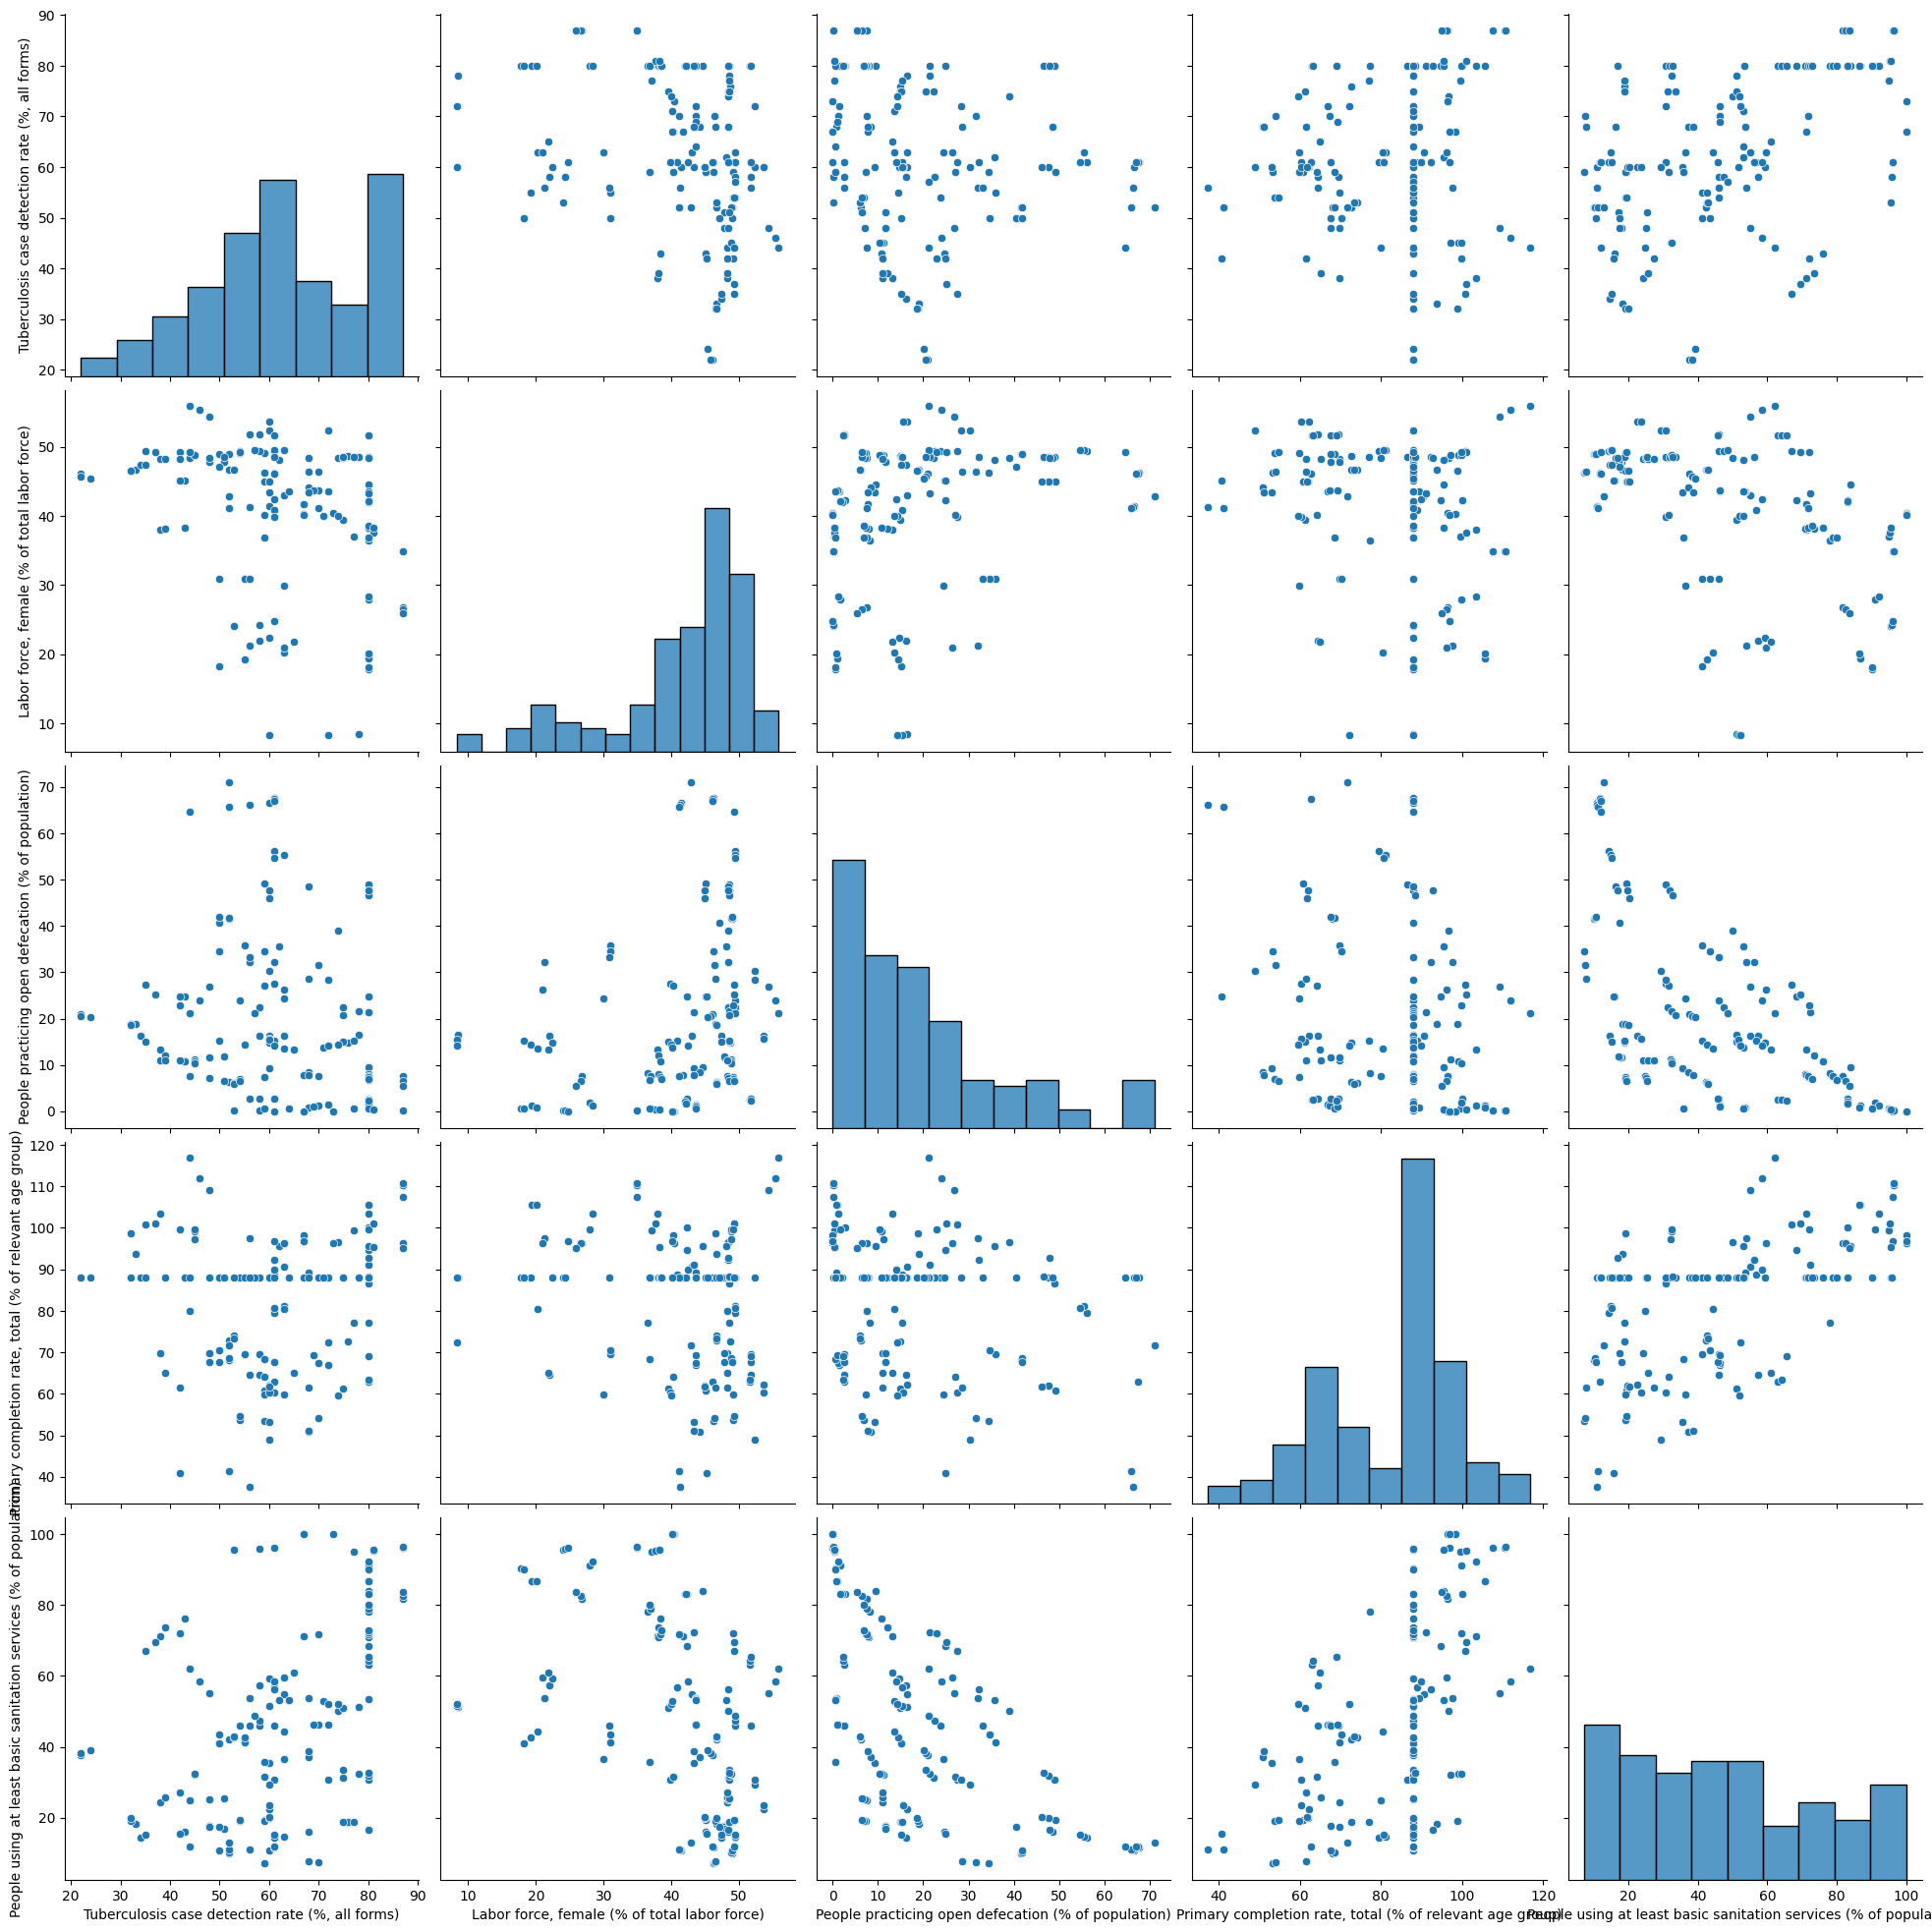

In [59]:
sns.pairplot(df_final, height=4)

### To conclude the above part, the features we have decided on are :
#### 1. Primary completion rate, total (% of relevant age group)
#### 2. People practicing open defecation (% of population)
#### 3. Tuberculosis case detection rate (%, all forms)
#### 4. Labor force, female (% of total labor force)### o Code and discussion on building the model 

### o Code and discussion on building the model 

### Our Hypotheses :

<img src="Images/Hypotheses.JPG"
     alt="Image"
     style="float: left; margin-right: 10px;" />

#### We will be first starting with linear as our first model, followed by quadratic, followed by cubic on the same training set.

### In order to choose the optimal number of iterations to run gradient descent, we will :
#### 1. Modify cohort gradient descent to store beta vectors instead of cost values
#### 2. WIth the list of beta vectors, we can find their respective r2 scores and plot them
#### 3. From the plots, we can visualise the point where model begins overfitting (r2 values begin to drop)
#### 4. Find the number of iterations before overfitting occurs by finding the highest r2 value
#### 5. Use optimal number of iterations to get final beta vector for that particular hypothesis

In [60]:
# Modified Cohort Functions

# Takes in a DataFrame, columns of features, columns of targets and returns DataFrame of features and targets.
def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

# Matrix multiplication of your feature matrix and beta vectors
def calc_linear(X, beta):
    return np.matmul(X, beta)

# Gives sum of square errors between predicted values (X*b) and actual values(y)
def compute_cost(X, y, beta):
    # m is number of data points, 
    J = 0
    predicted_value = calc_linear(X, beta) # y hat vector
    error = predicted_value - y # (y hat - y) vector
    # matmul is the sum over the squares of the two vectors
    error_sq = np.matmul(error.T, error) # y hat - y - transposed(mult(y hat, y))
    # [[error_sq]] is in this format
    J = 1/(2*X.shape[0]) * error_sq
    return J[0][0]

# First converts df_feature to Numpy array then adds a column of 1s as the 1st column of df_feature
def prepare_feature(df_feature):
    cols = len(df_feature.columns)
    df_feature = df_feature.to_numpy().reshape(-1, cols) # -1 is to auto set rows/cols
    X = np.concatenate((np.ones((df_feature.shape[0], 1)), df_feature), axis = 1)
    return X

# First converts df_target to Numpy array
def prepare_target(df_target):
    return df_target.to_numpy().reshape(-1, len(df_target.columns))

# Performs gradient descent algorithm for num_iters and returns the stored cost values after each iteration
# Returns final beta vector
def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0] # no. of data points in training set
    
    beta_storage = []
    
    # Loop through the gradient descent
    for i in range(num_iters):
        # Store current beta value
        beta_storage.append(beta.copy()) # Creates a shallow copy of beta, else it only stores reference to same beta object
        
        derivative_error_func = np.matmul(X.T, (calc_linear(X, beta) - y)) # [[dj/db0], [dj/db1]]
        # update beta
        beta -= alpha * (1/m) * derivative_error_func # [[b0], [b1]]
    
    # To store final beta value
    beta_storage.append(beta)
    return beta, beta_storage

# Computes predicted values matrix using df_feature matrix and beta column vector
def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return calc_linear(X, beta) # return a column of predicted values

# Splits data into a train set, validation set and test set
def split_data_with_validation(df_feature, df_target, random_state=None, validation_size=0.2, test_size=0.3): 
    np.random.seed(random_state) 
    indexes = df_feature.index # Returns a RangeIndex object that contains all indexes of df_feature
    j = int(validation_size* len(indexes)) # Size of validation set
    k = int(test_size* len(indexes)) # Size of test set
     
    test_index = set(np.random.choice(indexes, k, replace = False)) # Creates a set by randomly choosing k indices from indexes
    balance_index = set(indexes) - set(test_index) # Removes all the randomly chosen indexes used for test set
    validation_index = set(np.random.choice(list(balance_index), j, replace = False)) # Creates validation indexes
    train_index = balance_index - validation_index # Finds leftover indices to be used as training set indices
     
    df_feature_train = df_feature.loc[train_index, :] 
    df_feature_test = df_feature.loc[test_index, :] 
    df_target_train = df_target.loc[train_index, :] 
    df_target_test = df_target.loc[test_index, :] 
    df_feature_validation = df_feature.loc[validation_index, :] 
    df_target_validation = df_target.loc[validation_index, :] 
     
    return df_feature_train, df_feature_test, df_target_train, df_target_test, df_feature_validation, df_target_validation

# Calculates r2 score between actual and predicted values
def r2_score(y, ypred):
    ymean = np.mean(y) # mean from actual target
    mean_diff = y - ymean
    error = y - ypred
    
    #denominator
    ss_tot = np.matmul(mean_diff.T, mean_diff) # sum square of y-ymean
    
    # numerator
    ss_res = np.matmul(error.T, error) # sum sqaured of y-ypred
    
    r_2 = 1 - (ss_res/ss_tot)
    
    return r_2[0][0]

# Normalises values in the DataFrame
def normalize_z(df):
    dfout = df.copy()
    dfout = (dfout-dfout.mean(axis=0))/(dfout.std(axis=0))
    return dfout

# Calculation of MSE Score
def mse_score(y_actual, ypred):
    summ = 0
    n = len(y_actual)
    for i in range(0,n):  
        summ += ( y_actual[i] - ypred[i] )**2  
    MSE = summ/n  
    return MSE[0]

# Linear Model

In [61]:
df_feature, df_target = get_features_targets(df_final, ["Tuberculosis case detection rate (%, all forms)", "Labor force, female (% of total labor force)", "People practicing open defecation (% of population)", "Primary completion rate, total (% of relevant age group)"], ["People using at least basic sanitation services (% of population)"]) 

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test, df_feature_validation, df_target_validation = split_data_with_validation(df_feature, df_target, random_state=100, validation_size=0.2, test_size=0.3)

# normalize the train set feature using z normalization
df_feature_train_z = normalize_z(df_feature_train)

# repare the feature matrix, add 1 to the second dimension
X = prepare_feature(df_feature_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((5,1)) # [[0], [0]] 5 rows 1 col

# call the gradient_descent function which now stores beta values instead of cost values
beta, beta_storage = gradient_descent(X, target, beta, alpha, iterations)

# prepare the validation set targets
target = prepare_target(df_target_validation)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:73: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_train = df_feature.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:74: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_test = df_feature.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:75: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_train = df_target.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:76: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_test = df_target.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:77: FutureWarning

In [62]:
# Creating list of r2 values for the beta value from each iteration of gradient descent
r2_scores_w_iters = []
for beta_val in beta_storage:
    pred = predict(df_feature_validation, beta_val) # a vector of predicted values using trained beta
    r2 = r2_score(target, pred)
    r2_scores_w_iters.append(r2)

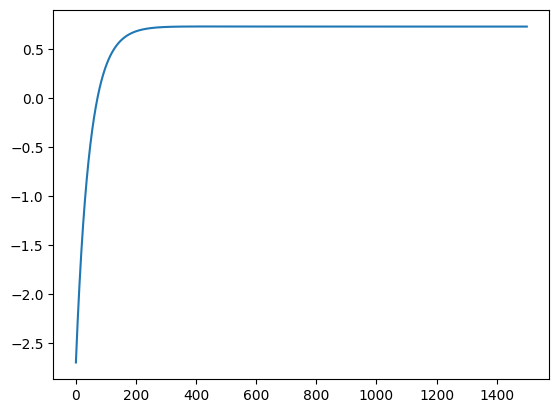

In [63]:
plt.plot(r2_scores_w_iters)

#### Looking at above plot, we observe an increase followed by a dip in r2 score at around 200-300 iterations for this linear model
#### The below code proceeds to find the optimal number of iterations that gives the greatest r2

In [64]:
index_of_highest_r = r2_scores_w_iters.index(max(r2_scores_w_iters))
print(index_of_highest_r, r2_scores_w_iters[index_of_highest_r])

434 0.7293789628734473


#### From this, we observed that by using the cohort's number of iterations, the resulting beta vectors result in an overfitted model. Instead, we should reduce the number of iterations for that model to 250 and use the beta vector at that particular iteration of gradient descent.


In [65]:
# Final beta values for Linear Model
beta_linear_final = beta_storage[index_of_highest_r]
r2_linear_final = r2_scores_w_iters[index_of_highest_r]
print(f'Final Beta Value for Linear Model : \n{beta_linear_final} ')

Final Beta Value for Linear Model : 
[[ 45.83566474]
 [  6.32813752]
 [ -6.75572447]
 [-11.39550045]
 [ 10.36841601]] 


#### MSE Score for Linear Model

In [66]:
prediction_with_final_beta = predict(df_feature_validation, beta_linear_final)
mse_linear = mse_score(target, prediction_with_final_beta)
print(mse_linear)

217.65180948228462


### We will proceed with the same methodology with the remaining 2 hypotheses.

# Quadratic Model

In [67]:
# Adding Quadratic Features to df_final which is the square of each of our features
df_final["Tuberculosis case detection rate (%, all forms)^2"] = df_final["Tuberculosis case detection rate (%, all forms)"]**2
df_final["Labor force, female (% of total labor force)^2"] = df_final["Labor force, female (% of total labor force)"]**2
df_final["People practicing open defecation (% of population)^2"] = df_final["People practicing open defecation (% of population)"]**2
df_final["Primary completion rate, total (% of relevant age group)^2"] = df_final["Primary completion rate, total (% of relevant age group)"]**2

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\4289727476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Tuberculosis case detection rate (%, all forms)^2"] = df_final["Tuberculosis case detection rate (%, all forms)"]**2
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\4289727476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Labor force, female (% of total labor force)^2"] = df_final["Labor force, female (% of total labor force)"]**2
C:\Users\Lucas\AppData\Local\Temp\ipyker

In [68]:
df_feature, df_target = get_features_targets(df_final, ["Tuberculosis case detection rate (%, all forms)", "Labor force, female (% of total labor force)", "People practicing open defecation (% of population)", "Primary completion rate, total (% of relevant age group)", "Tuberculosis case detection rate (%, all forms)^2", "Labor force, female (% of total labor force)^2", "People practicing open defecation (% of population)^2", "Primary completion rate, total (% of relevant age group)^2"], ["People using at least basic sanitation services (% of population)"]) # , "Newborns protected against tetanus (%)"

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test, df_feature_validation, df_target_validation = split_data_with_validation(df_feature, df_target, random_state=100, validation_size=0.2, test_size=0.3)

# normalize the train set feature using z normalization
df_feature_train_z = normalize_z(df_feature_train)

# prepare the feature matrix, add 1 to the second dimension
X = prepare_feature(df_feature_train_z)
target = prepare_target(df_target_train)

iterations = 500000
alpha = 0.01
beta = np.zeros((9,1)) # [[0], [0]] 9 rows 1 col

# call the gradient_descent function which now stores beta values instead of cost values
beta, beta_storage = gradient_descent(X, target, beta, alpha, iterations)

# prepare the validation set targets
target = prepare_target(df_target_validation)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:73: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_train = df_feature.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:74: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_test = df_feature.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:75: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_train = df_target.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:76: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_test = df_target.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:77: FutureWarning

In [69]:
# Creating list of r2 values for the beta value from each iteration of gradient descent
r2_scores_w_iters = []
for beta_val in beta_storage:
    pred = predict(df_feature_validation, beta_val) # a vector of predicted values using trained beta
    r2 = r2_score(target, pred)
    r2_scores_w_iters.append(r2)

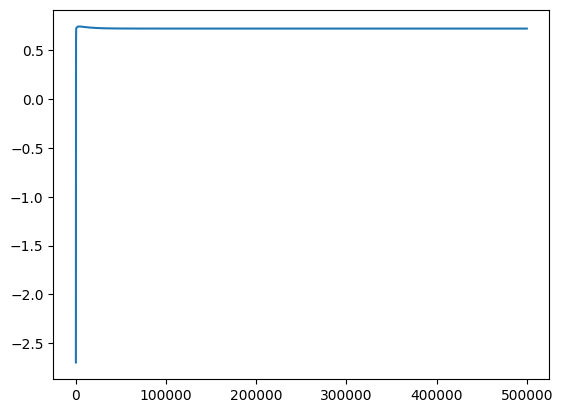

In [70]:
plt.plot(r2_scores_w_iters)

#### For the quadratic model, it can be observed that the optimal number of iterations is 385010 which gives the highest r2 value.

In [71]:
index_of_highest_r = r2_scores_w_iters.index(max(r2_scores_w_iters))
print(index_of_highest_r, r2_scores_w_iters[index_of_highest_r])

3808 0.7430045176015221


In [72]:
# Final beta values for Quadratic Model
beta_quadratic_final = beta_storage[index_of_highest_r]
r2_quadratic_final = r2_scores_w_iters[index_of_highest_r]
print(f'Final Beta Value for Quadratic Model : \n{beta_quadratic_final} ')

Final Beta Value for Quadratic Model : 
[[ 4.64278437e+01]
 [ 6.19107880e-03]
 [ 3.99315920e+00]
 [-1.79973179e+01]
 [-4.86205872e+00]
 [ 5.79648919e+00]
 [-1.06359243e+01]
 [ 6.71269263e+00]
 [ 1.53743751e+01]] 


### MSE Score for Quadratic Model

In [73]:
prediction_with_final_beta = predict(df_feature_validation, beta_quadratic_final)
mse_quadratic = mse_score(target, prediction_with_final_beta)
print(mse_quadratic)

206.69321338327353


# Cubic Model

In [74]:
# Adding Cubic Features to df_final which is the cube of each of our features
df_final["Tuberculosis case detection rate (%, all forms)^3"] = df_final["Tuberculosis case detection rate (%, all forms)"]**3
df_final["Labor force, female (% of total labor force)^3"] = df_final["Labor force, female (% of total labor force)"]**3
df_final["People practicing open defecation (% of population)^3"] = df_final["People practicing open defecation (% of population)"]**3
df_final["Primary completion rate, total (% of relevant age group)^3"] = df_final["Primary completion rate, total (% of relevant age group)"]**3

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\673712628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Tuberculosis case detection rate (%, all forms)^3"] = df_final["Tuberculosis case detection rate (%, all forms)"]**3
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\673712628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Labor force, female (% of total labor force)^3"] = df_final["Labor force, female (% of total labor force)"]**3
C:\Users\Lucas\AppData\Local\Temp\ipykerne

In [86]:
df_feature, df_target = get_features_targets(df_final, ["Tuberculosis case detection rate (%, all forms)", "Labor force, female (% of total labor force)", "People practicing open defecation (% of population)", "Primary completion rate, total (% of relevant age group)", "Tuberculosis case detection rate (%, all forms)^2", "Labor force, female (% of total labor force)^2", "People practicing open defecation (% of population)^2", "Primary completion rate, total (% of relevant age group)^2", "Tuberculosis case detection rate (%, all forms)^3", "Labor force, female (% of total labor force)^3", "People practicing open defecation (% of population)^3", "Primary completion rate, total (% of relevant age group)^3"], ["People using at least basic sanitation services (% of population)"]) # , "Newborns protected against tetanus (%)"

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test, df_feature_validation, df_target_validation = split_data_with_validation(df_feature, df_target, random_state=100, validation_size=0.2, test_size=0.3)

# normalize the train set feature using z normalization
df_feature_train_z = normalize_z(df_feature_train)

# prepare the feature matrix, add 1 to the second dimension
X = prepare_feature(df_feature_train_z)
target = prepare_target(df_target_train)

iterations = 1000000
alpha = 0.01
beta = np.zeros((13,1)) # [[0], [0]] 13 rows 1 col

# call the gradient_descent function which now stores beta values instead of cost values
beta, beta_storage = gradient_descent(X, target, beta, alpha, iterations)

# prepare the validation set targets
target = prepare_target(df_target_validation)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:73: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_train = df_feature.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:74: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_feature_test = df_feature.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:75: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_train = df_target.loc[train_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:76: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_target_test = df_target.loc[test_index, :]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_5160\2866074122.py:77: FutureWarning

In [ ]:
# Creating list of r2 values for the beta value from each iteration of gradient descent
r2_scores_w_iters = []
for beta_val in beta_storage:
    pred = predict(df_feature_validation, beta_val) # a vector of predicted values using trained beta
    r2 = r2_score(target, pred)
    r2_scores_w_iters.append(r2)

In [ ]:
plt.plot(r2_scores_w_iters)

#### For the cubic model, it can be observed that the optimal number of iterations is 726487 which gives the highest r2 value.

In [78]:
index_of_highest_r = r2_scores_w_iters.index(max(r2_scores_w_iters))
print(index_of_highest_r, r2_scores_w_iters[index_of_highest_r])

1000000 0.7473350013696798


In [79]:
# Final beta values for Cubic Model
beta_cubic_final = beta_storage[index_of_highest_r]
r2_cubic_final = r2_scores_w_iters[index_of_highest_r]
print(f'Final Beta Value for Cubic Model : \n{beta_cubic_final} ')

Final Beta Value for Cubic Model : 
[[ 46.4278437 ]
 [-67.04869991]
 [ 43.68986564]
 [-49.18545279]
 [-10.36747858]
 [158.82554702]
 [-86.5890694 ]
 [ 85.86910529]
 [ -1.97463121]
 [-89.70804226]
 [ 36.66736059]
 [-50.82000218]
 [ 22.85886096]] 


### MSE Score for Cubic Model

In [80]:
prediction_with_final_beta = predict(df_feature_validation, beta_cubic_final)
mse_cubic = mse_score(target, prediction_with_final_beta)
print(mse_cubic)

203.2103443569737


# Choosing the Best Model based on MSE and R2

Text(0, 0.5, 'MSE')

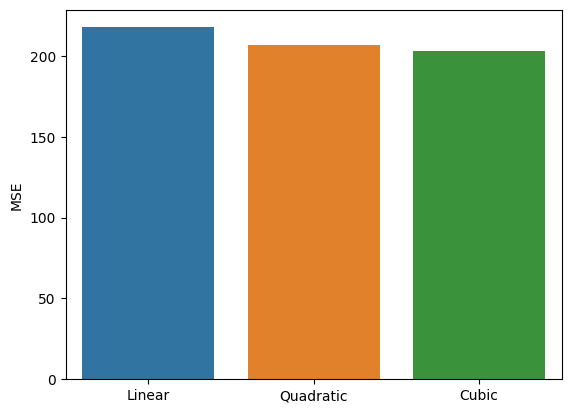

In [81]:
sns.barplot(x=["Linear", "Quadratic", "Cubic"], y = [mse_linear, mse_quadratic, mse_cubic])
plt.ylabel("MSE")

Text(0, 0.5, 'R2 Score')

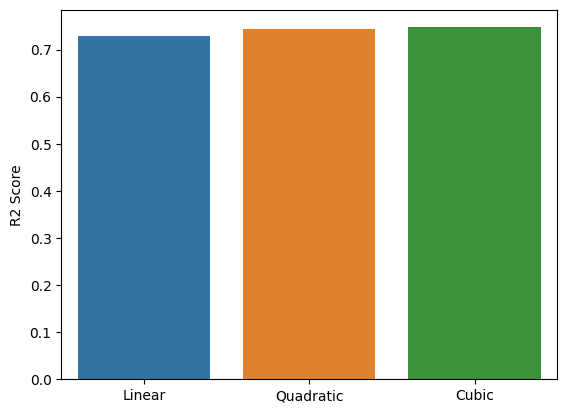

In [82]:
sns.barplot(x=["Linear", "Quadratic", "Cubic"], y = [r2_linear_final, r2_quadratic_final, r2_cubic_final])
plt.ylabel("R2 Score")

### Finally, we choose the cubic model because it has the lowest MSE compared to the other models we have tried previously.

## ● Model Evaluation 

### o Discussion on the chosen metric to evaluate your final model, how that model compares with your earlier attempts, any mathematical details, and all resources consulted 


### We will be using Root Mean Squared Error (RMSE) as our final metric to evaluate our final model. The RMSE has units of % and its scale ranges from 0 to 100 as our target refers to the 'People using at least basic sanitation services (% of population)'. Hence, our predicted values should be within the range where lower indicates that the uncertainty of prediction is less.

### We will first be reporting the R2 score of our model using the test set.

### o Code and results of the metric on your test data set 

In [83]:
# Calculation of r2 value with test set

# normalize the test feature set feature using z normalization
df_feature_test_z = normalize_z(df_feature_test)

# prepare the feature matrix, add 1 to the second dimension
X = prepare_feature(df_feature_test_z)
target = prepare_target(df_target_test)

pred = predict(df_feature_test, beta_cubic_final) # a vector of predicted values using trained beta
r2 = r2_score(target, pred)
print(r2)

0.6911489181392939


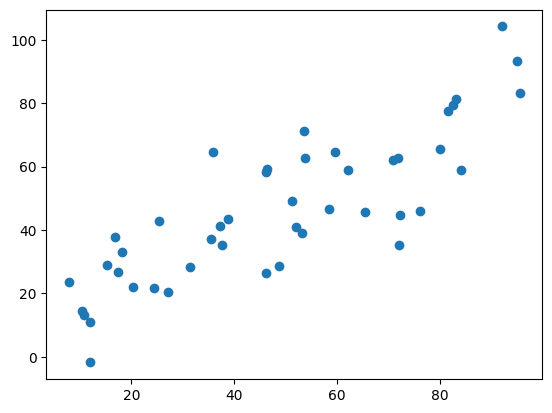

In [84]:
plt.scatter(target,pred)

In [85]:
# Calculation of RMSE
import math

prediction_with_cubic = predict(df_feature_test, beta_cubic_final)
mse_cubic = mse_score(target, prediction_with_cubic)
rmse = math.sqrt(mse_cubic)
print(rmse)

14.4190788546719


### To conclude, our model has an average RMSE of 14%. 